In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:


# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# Importing models and compiling them
#model = tf.keras.models.load_model(r'..\..\..\build\saved_model\VGG19_TransferLearning\HDF5\VGG19_TransferLearning.h5', compile=True)
model = tf.keras.models.load_model(r'/content/drive/Othercomputers/PC/msc_final_project/TPU/build/saved_model/MobileNetV3Large_TransferLearning/HDF5/MobileNetV3Large_TransferLearning.h5', compile=True)

# Show the model architecture
#model.summary()



## 1    Preparing and pre-processing data

In [ ]:
# Utility functions
def print_shapes(train_images, test_images, train_labels, test_labels):
  print(f"train_images: {train_images.shape}\n"\
      f"test_images: {test_images.shape}\n"\
      f"train_labels: {train_labels.shape}\n"\
      f"test_labels: {test_labels.shape}\n")

In [ ]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
print_shapes(train_images, test_images, train_labels, test_labels)

170508288/170498071 [==============================] - 3s 0us/step
train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 1)
test_labels: (10000, 1)



In [ ]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10 
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

train_images = train_images / 255
test_images = test_images / 255

train_images = train_images.reshape((-1, height, width, channels))
test_images = test_images.reshape((-1, height, width, channels))

train_labels = tf.keras.utils.to_categorical(train_labels, nb_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, nb_classes)

print_shapes(train_images, test_images, train_labels, test_labels)

train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 10)
test_labels: (10000, 10)



## 2    Implementing the I-FGSM Method with Keras and TensorFlow

In [ ]:
# Function to calculate adversary noise
def generate_adversary(image, label):
  '''Generates adversarial noise for a given image and label
  Args:
    image(np.array):  input image, shape like (1, height, width, channels)
    label(int): label of the image, shape like (nb_classes, )
  
  Returns:
    sign_grad(tf.Tensor): adversarial noise, should be changed to numpy array before add to the image.T
                          shape like (1, height, width, channels)
  '''

  # Change the image to a tensor
  image = tf.cast(image, tf.float32)

  #record gradients
  with tf.GradientTape() as tape:

    tape.watch(image)

    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
    
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

In [ ]:
def I_FSGM(image, label, alpha, epsilon):
    '''Performs I-FSGM attack on a given image and label
    Args:
        image(np.array):  input image, shape like (height, width, channels)
        label(int): label of the image, shape like (nb_classes, )
        alpha(float): alpha parameter for I-FSGM
        epsilon(int): epsilon parameter for I-FSGM
    
    Examples:
        >>> tmp = I_FSGM(train_images[0], train_labels[0], 0.1, 5)
    
    Returns:
        adv_image(np.array): adversarial image, shape like (height, width, channels)
    '''

    image = image.reshape(1,32,32,3)
    
    for i in range(int(min(epsilon+4, 1.25 * epsilon))):

        
        img_adv = (image + alpha * generate_adversary(image, label).numpy()).reshape(32,32,3)

        
        for j in range(len(img_adv)):
            for k in range(len(img_adv[j])):
                for l in range(len(img_adv[j][k])):

                    img_adv[j][k] = np.clip(img_adv[j][k] , image[0][j][k]  - epsilon/255, image[0][j][k]  + epsilon/255)
                
                    if img_adv[j][k][l] > 1:
                        img_adv[j][k][l] = 1
                    elif img_adv[j][k][l] < 0:
                        img_adv[j][k][l] = 0

        image = img_adv.reshape(1,32,32,3)

    return image.reshape(32,32,3)

### 2.1 Use a sample to test the accuracy after attack and plot it

In [ ]:
index_tmp = random.randint(0, len(train_images)-1)

# used to generate adversarial image
image_test1 = train_images[index_tmp]
image_test1_label = train_labels[index_tmp]

# original input image
image_test2 = image_test1.copy()

In [ ]:
image_test1_adv = I_FSGM(image_test1, image_test1_label, 0.1, 5)

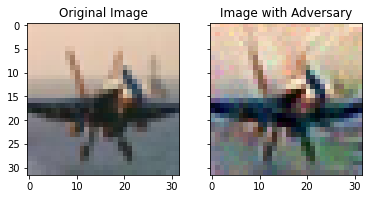

In [ ]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image_test2)
ax1.set_title("Original Image")
ax2.imshow(image_test1_adv)
ax2.set_title("Image with Adversary")
plt.show()

original model prediction: 
airplane


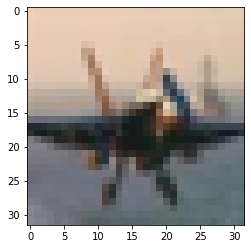

In [ ]:
plt.imshow(image_test2)
print(f'original model prediction: \n{label_names[model(image_test2.reshape(1,32,32,3)).numpy().argmax()]}')


after attack model prediction: 
airplane


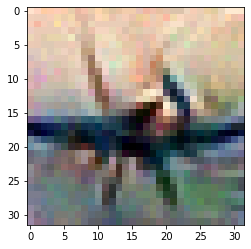

In [ ]:
plt.imshow(image_test1_adv)
print(f'after attack model prediction: \n{label_names[model(image_test1_adv.reshape(1,32,32,3)).numpy().argmax()]}')


## 3    Let's try this out for different values of epsilon and observe the resultant image.

In [ ]:
def display_images(image, image_label, image_labels, alphas, epsilons, model):
  '''Displays images with adversarial noise
  Args:
    image(np.array):  input image, shape like (height, width, channels)
    image_label(numpy.ndarray): label of the image, shape like (nb_classes, )
      array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)
    image_labels(list): list of labels of the images, shape like (nb_classes, )
    alphas(list): list of alpha parameters for I-FSGM
    epsilons(list): list of epsilon parameters for I-FSGM
    model(tf.keras.Model): model to be used for adversarial attack

  Examples:
      >>> display_images(train_images[0], train_labels[0], label_names, [0.1, 0.2, 0.3], [1, 3, 5], model)

  '''

  fix, axs = plt.subplots(len(alphas), len(epsilons), figsize=(20, 20))

  for i in range(len(alphas)):
    for j in range(len(epsilons)):
      adv_image = I_FSGM(image, image_label, alphas[i], epsilons[j])
      axs[i,j].imshow(adv_image)
      axs[i,j].set_title(f'alpha: {alphas[i]}, epsilon: {epsilons[j]}, {image_labels[model(adv_image.reshape(1,32,32,3)).numpy().argmax()]}', fontsize=10)
      axs[i,j].axis('off')


In [ ]:
#display_images(image_test1, image_test1_label, [0.1, 0.5, 1], [5, 10, 15])

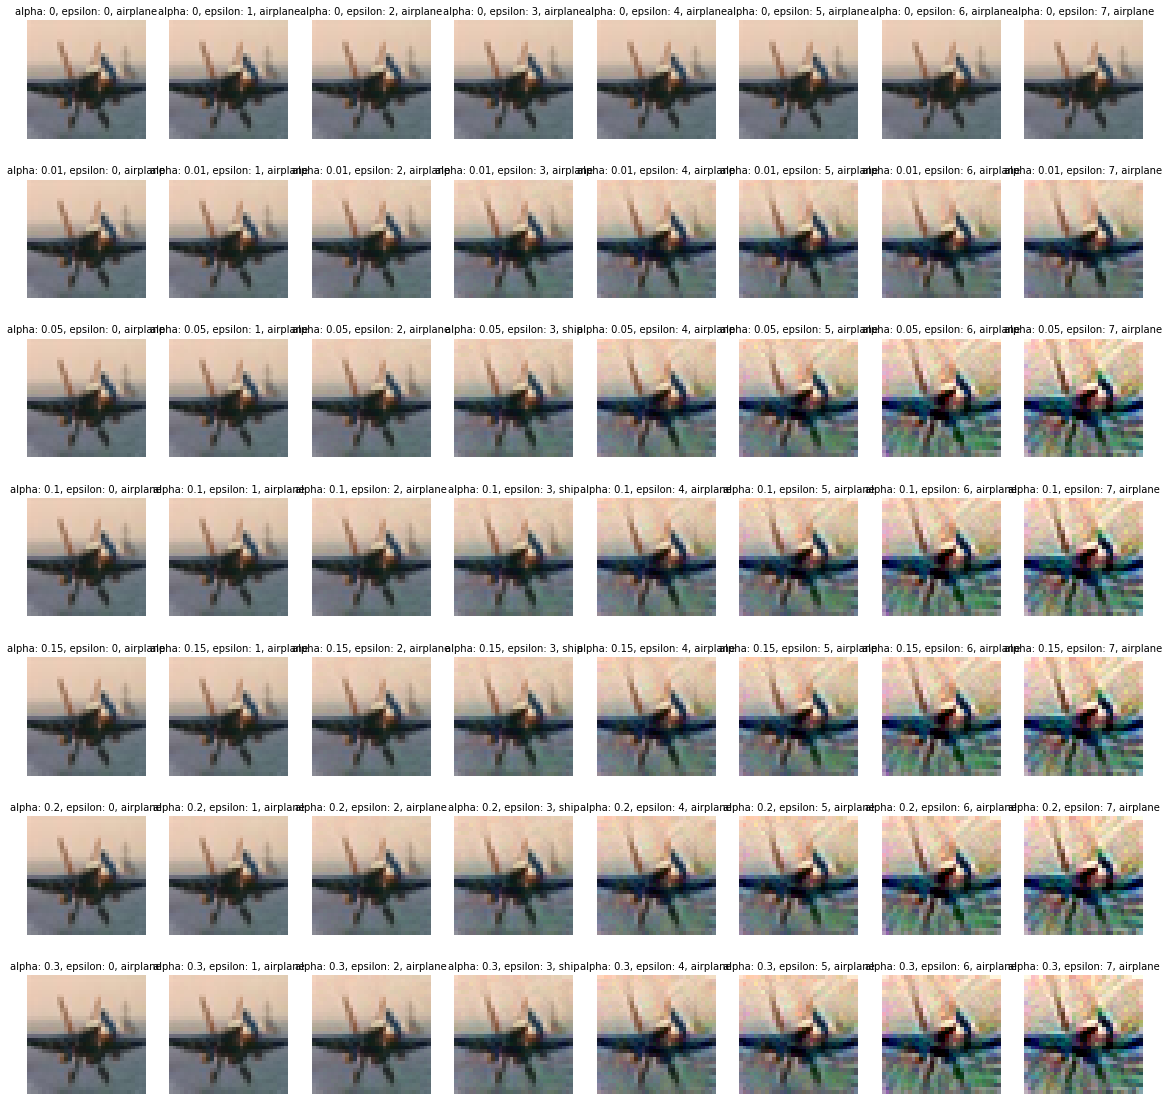

In [ ]:

alphas = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
epsilons = [0, 1, 2, 3, 4, 5, 6, 7]
#descriptions_epsilon = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
#descriptions_alpha = [('Alpha = {:0.3f}'.format(alpha) if alpha else 'Input') for alpha in alphas]

display_images(image_test2, image_test1_label, label_names, alphas, epsilons, model)

## 4    create a adversary noise set and test the model right rate

In [ ]:
def create_adversarty_images_set(image_set, label_set, total_label, alpha, epsilon):
    '''A script to create adversarial images set

    Args:
        image_set: image set which need to be adversarized. shape like (len(image_set), height, width, channels)
        label_set: label set of the image set.  shape like (len(image_set), nb_classes)
        total_label: whole label set
        epsilon: int number of epsilon

    Returns:
        adversarial_images_set: adversarial images set. shape like (len(image_set), height, width, channels)
    '''


    right_count_original = 0
    right_count_adversary = 0

    for i in range(len(image_set)):
        image = image_set[i]
        label = label_set[i]

        #label_name_original = total_label[np.where(label==1)[0][0]]
        label_original = np.where(label==1)[0][0]
        

        #   Create adversarial image (adding noise to original image)
        adversarial = I_FSGM(image, label, alpha, epsilon).reshape(1, 32, 32 ,3)

        #orig_pred_name = total_label[model(image).numpy().argmax()]
        orig_pred = model(image.reshape(1, 32, 32 ,3)).numpy().argmax()

        #adversarial_pred_name = total_label[model(adversarial).numpy().argmax()]      
        adversarial_pred = model(adversarial).numpy().argmax()


        #   calculate accuracy of original image
        if orig_pred == label_original:
            right_count_original += 1  

        if adversarial_pred == label_original:
            right_count_adversary += 1
    

    accuary_original = right_count_original/len(image_set)
    accuary_adv = right_count_adversary/len(image_set)

    print(f"epsilon: {epsilon}, 'alpha': {alpha}")    
    print(f'Accuracy of original image before attack: {accuary_original}')
    print(f'Accuracy of original image after attack {accuary_adv}')

    return f"'epsilon': {epsilon}, 'alpha': {alpha}, 'accuary_original': {accuary_original}, 'accuary_adv': {accuary_adv}"

In [ ]:
def test_different_input_epsilon(image_set, image_label_set, label_names_set, alpha, epsilons, store_file_path):
  for i, epsilon in enumerate(epsilons):
    for j, alpha in enumerate(alphas):
    
      information = create_adversarty_images_set(image_set, image_label_set, label_names, alpha, epsilon)

      with open(store_file_path, 'a') as f:
        f.write(information + '\n')



### 4.1 Use test_images for test

In [ ]:
alphas = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
epsilons = [1, 2, 3, 4, 5, 6, 7]

In [ ]:
test_different_input_epsilon(test_images, test_labels, label_names, alphas, epsilons, '/content/drive/Othercomputers/PC/msc_final_project/TPU/attack/whitebox/I-FSGM/information/MobileNetV3Large_Information.txt')

epsilon: 1, 'alpha': 0
Accuracy of original image before attack: 0.4189
Accuracy of original image after attack 0.4189
epsilon: 1, 'alpha': 0.01
Accuracy of original image before attack: 0.4189
Accuracy of original image after attack 0.407
epsilon: 1, 'alpha': 0.05
Accuracy of original image before attack: 0.4189
Accuracy of original image after attack 0.407
